In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

pd.set_option("mode.copy_on_write", True)

# Load merged dataset
url = r"C:\Users\sejal\Dropbox\PC\Desktop\final_merged.csv"
final_merged_data = pd.read_csv(url)

# Quick checks
print(final_merged_data.shape)
print(final_merged_data.head())
print(final_merged_data.columns)

# Ensure county code / FIPS are string to preserve leading zeros
if "County Code" in final_merged_data.columns:
    final_merged_data["County Code"] = final_merged_data["County Code"].astype(str).str.zfill(5)


(271967, 10)
  State    County    Total_MME             County.1  County Code  \
0    GA   APPLING  5201.267675   Appling County, GA        13001   
1    GA  ATKINSON  1023.390277  Atkinson County, GA        13003   
2    GA     BACON  3824.818008     Bacon County, GA        13005   
3    GA   BALDWIN  7352.035690   Baldwin County, GA        13009   
4    GA     BANKS  2115.657581     Banks County, GA        13011   

                  Drug/Alcohol Induced Cause Drug/Alcohol Induced Cause Code  \
0  All other non-drug and non-alcohol causes                              O9   
1  All other non-drug and non-alcohol causes                              O9   
2  All other non-drug and non-alcohol causes                              O9   
3  All other non-drug and non-alcohol causes                              O9   
4  All other non-drug and non-alcohol causes                              O9   

   Deaths  year  Population  
0     215  2015       18423  
1      81  2015        8340  
2     1

In [27]:
final_merged_data.groupby("State")["Total_MME"].sum().sort_values()


State
MT    2.023251e+07
ID    3.522268e+07
SC    2.679344e+08
WA    6.999947e+08
OR    4.205827e+10
GA    1.488386e+12
NC    1.522300e+12
FL    1.397442e+13
Name: Total_MME, dtype: float64

In [28]:
final_merged_data.groupby("State")["year"].unique()


State
FL    [2015, 2006, 2007, 2008, 2009, 2010, 2011, 201...
GA    [2015, 2006, 2007, 2008, 2009, 2010, 2011, 201...
ID    [2006, 2007, 2008, 2009, 2010, 2011, 2012, 201...
MT    [2006, 2007, 2008, 2009, 2010, 2011, 2012, 201...
NC    [2015, 2006, 2007, 2008, 2009, 2010, 2011, 201...
OR    [2015, 2006, 2007, 2008, 2009, 2010, 2011, 201...
SC    [2015, 2006, 2007, 2008, 2009, 2010, 2011, 201...
WA    [2015, 2006, 2007, 2008, 2009, 2010, 2011, 201...
Name: year, dtype: object

In [29]:
final_merged_data["opioid_per_capita_test"] = (
    final_merged_data["Total_MME"] / final_merged_data["Population"]
)

final_merged_data.groupby("State")["opioid_per_capita_test"].mean()


State
FL     84.393240
GA    115.231752
ID      0.163356
MT      0.165225
NC    246.789642
OR     13.819361
SC      0.116103
WA      0.057422
Name: opioid_per_capita_test, dtype: float64

In [30]:
final_merged_data[
    (final_merged_data["State"] == "WA") &
    (final_merged_data["year"].between(2006, 2011))
][["State", "year", "Total_MME", "Population"]].head(20)


,State,year,Total_MME,Population
9300,WA,2006,191.702415,16997
9301,WA,2007,171.901456,17413
9302,WA,2008,201.848405,17782
9303,WA,2009,177.739263,18405
9304,WA,2010,218.103857,18821
9305,WA,2010,218.103857,18790
9306,WA,2011,323.806406,18877
9311,WA,2006,182.337988,21133
9312,WA,2007,132.175549,21188
9313,WA,2008,502.547503,21393


In [35]:
# States for WA policy
states_to_check = ["WA", "OR", "ID", "MT"]

# Build clean panel for 2006–2011
panel = final_merged_data[
    (final_merged_data["State"].isin(states_to_check)) &
    (final_merged_data["year"].between(2006, 2011))
][[
    "State", "County Code", "year", "Population", "Total_MME"
]].copy()

# Compute opioid per capita (correct)
panel["opioid_per_capita"] = panel["Total_MME"] / panel["Population"]


In [36]:
# Check for missing values in key variables
panel

,State,County Code,year,Population,Total_MME,opioid_per_capita
5382,MT,30001,2006,9012,110.250875,0.012234
5383,MT,30001,2007,9028,84.534516,0.009364
5384,MT,30001,2008,9166,103.902239,0.011336
5385,MT,30001,2009,9200,44.351583,0.004821
5386,MT,30001,2010,9253,91.082596,0.009844
...,...,...,...,...,...,...
271959,ID,16087,2008,10095,1092.829612,0.108255
271960,ID,16087,2009,10173,1413.351870,0.138932
271961,ID,16087,2010,10205,1715.557262,0.168109
271962,ID,16087,2010,10177,1715.557262,0.168572


In [37]:
panel.columns

Index(['State', 'County Code', 'year', 'Population', 'Total_MME',
       'opioid_per_capita'],
      dtype='object')

In [ ]:
panel.head()

State
ID     1713
MT     1925
OR     5684
WA    14166
dtype: int64

In [39]:
panel.isna().sum()

State                0
County Code          0
year                 0
Population           0
Total_MME            0
opioid_per_capita    0
dtype: int64

In [40]:
panel.groupby("State").size()

State
ID     1713
MT     1925
OR     5684
WA    14166
dtype: int64

In [41]:
# Ensure numeric values before computing per capita rates
panel["Population"] = pd.to_numeric(panel["Population"], errors="coerce")
panel["Total_MME"] = pd.to_numeric(panel["Total_MME"], errors="coerce")

# Recompute opioid_per_capita after coercion
panel["opioid_per_capita"] = panel["Total_MME"] / panel["Population"]


In [42]:
# Treated indicator: Washington = 1, control states = 0
panel["treated"] = (panel["State"] == "WA").astype(int)

In [43]:
panel.groupby("State")["treated"].mean()

State
ID    0.0
MT    0.0
OR    0.0
WA    1.0
Name: treated, dtype: float64

### Parallel Trend Plot for Opioid Per Capita (WA vs Controls)

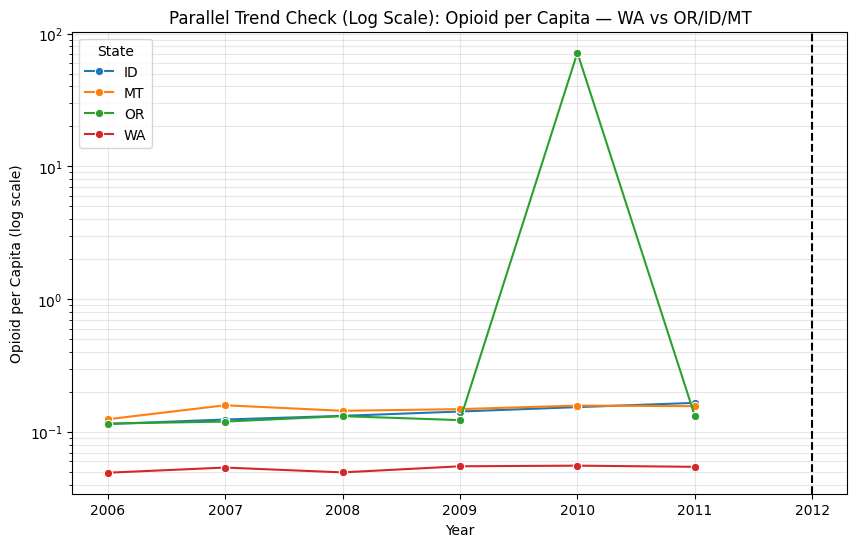

In [44]:
trend_df = (
    panel.groupby(["State", "year"])["opioid_per_capita"]
    .mean()
    .reset_index()
)


plt.figure(figsize=(10,6))
sns.lineplot(
    data=trend_df,
    x="year",
    y="opioid_per_capita",
    hue="State",
    marker="o"
)
plt.yscale("log")
plt.axvline(2012, color="black", linestyle="--")
plt.title("Parallel Trend Check (Log Scale): Opioid per Capita — WA vs OR/ID/MT")
plt.xlabel("Year")
plt.ylabel("Opioid per Capita (log scale)")
plt.grid(True, which="both", alpha=0.3)
plt.show()




> The plot does not match the proposal because the proposal figure is conceptual, but the real ARCOS dataset contains strong county-level volatility and outliers, especially in Oregon: which distort the shape of the lines.

In [45]:
states_wo_or = ["WA", "ID", "MT"]

panel_wo_or = final_merged_data[
    (final_merged_data["State"].isin(states_wo_or)) &
    (final_merged_data["year"].between(2006, 2011))
].copy()

panel_wo_or["opioid_per_capita"] = (
    panel_wo_or["Total_MME"] / panel_wo_or["Population"]
)

trend_wo_or = (
    panel_wo_or.groupby(["State", "year"])["opioid_per_capita"]
    .mean()
    .reset_index()
)


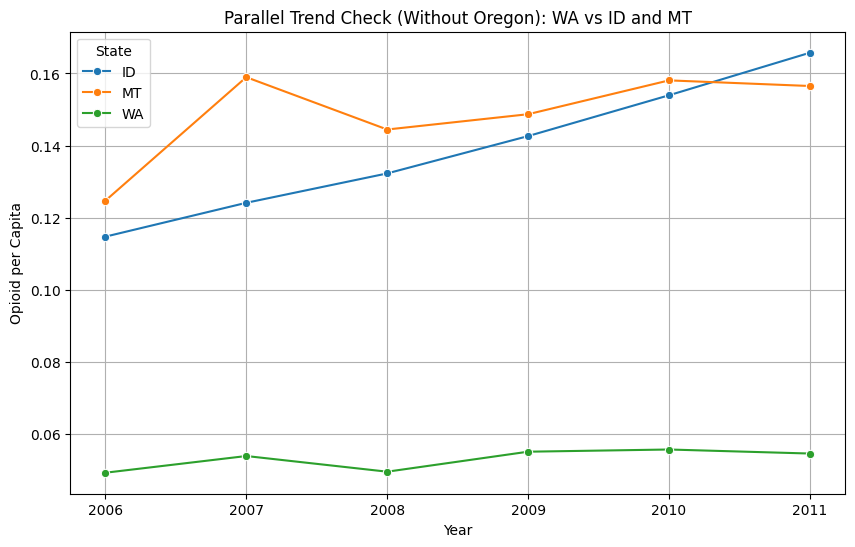

In [46]:
plt.figure(figsize=(10,6))

sns.lineplot(
    data=trend_wo_or,
    x="year",
    y="opioid_per_capita",
    hue="State",
    marker="o"
)

plt.title("Parallel Trend Check (Without Oregon): WA vs ID and MT")
plt.xlabel("Year")
plt.ylabel("Opioid per Capita")
plt.grid(True)
plt.show()


In [47]:
# Plot individual states with WA

def plot_pair(state):
    df_pair = final_merged_data[
        (final_merged_data["State"].isin(["WA", state])) &
        (final_merged_data["year"].between(2006, 2011))
    ].copy()

    df_pair["opioid_per_capita"] = (
        df_pair["Total_MME"] / df_pair["Population"]
    )

    trend_pair = (
        df_pair.groupby(["State", "year"])["opioid_per_capita"]
        .mean()
        .reset_index()
    )

    plt.figure(figsize=(8,5))
    sns.lineplot(
        data=trend_pair,
        x="year",
        y="opioid_per_capita",
        hue="State",
        marker="o"
    )
    plt.xlabel("Year")
    plt.ylabel("Opioid per Capita")
    plt.title(f"Parallel Trend Check: WA vs {state}")
    plt.grid(True)
    plt.show()


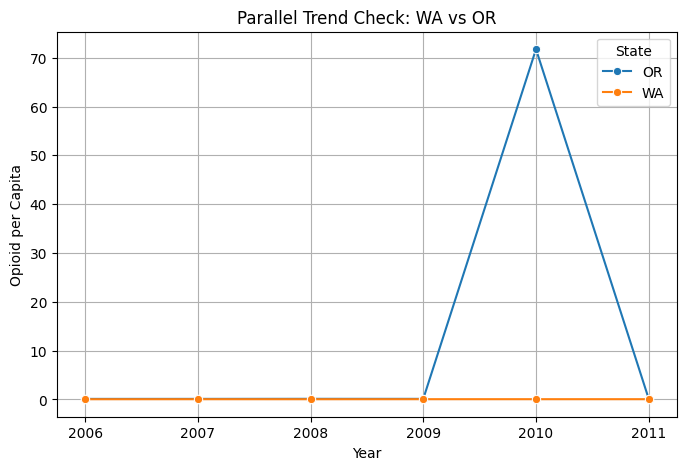

In [48]:
plot_pair("OR")


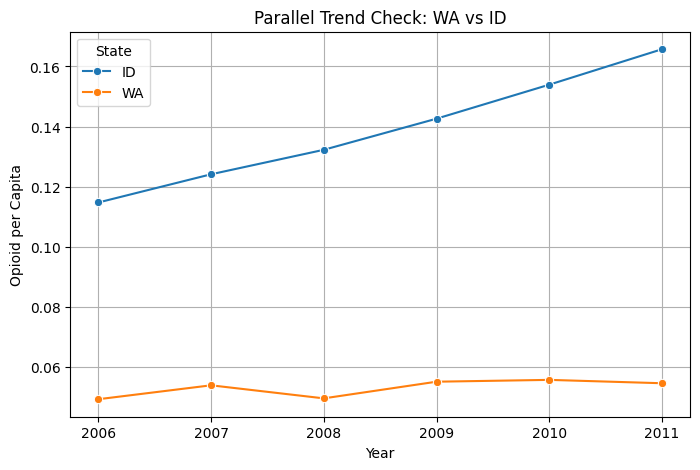

In [49]:
plot_pair("ID")


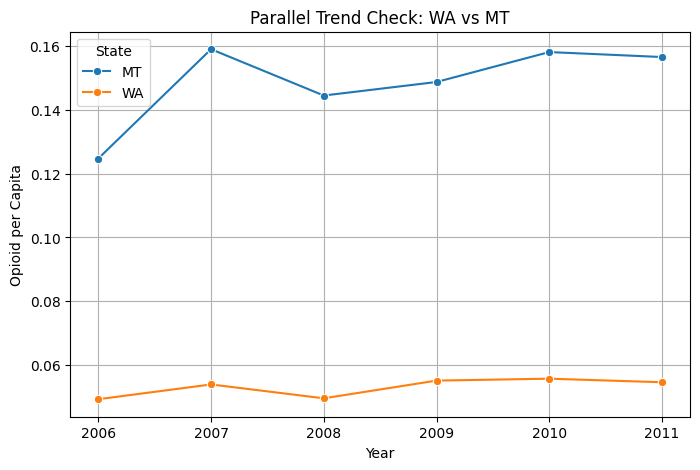

In [50]:
plot_pair("MT")


### Difference-in-Differences (DID) for Washington’s 2012 Opioid Regulation

Outcome: opioid_per_capita = Total_MME / Population

Treatment group: Washington (WA)

Control group: Oregon (OR), Idaho (ID), Montana (MT)

Pre-policy period: 2006–2011

Post-policy period: 2012–2014

In [51]:
did_states = ["WA", "OR", "ID", "MT"]

did_panel = final_merged_data[
    (final_merged_data["State"].isin(did_states)) &
    (final_merged_data["year"].between(2006, 2014))
].copy()

# Outcome variable
did_panel["opioid_per_capita"] = did_panel["Total_MME"] / did_panel["Population"]

# DID variables
did_panel["treated"] = (did_panel["State"] == "WA").astype(int)
did_panel["post"] = (did_panel["year"] >= 2012).astype(int)


### Main DID model — WA vs ALL controls combined

In [52]:
import statsmodels.formula.api as smf

did_all = smf.ols(
    "opioid_per_capita ~ treated*post + C(State) + C(year)",
    data=did_panel
).fit(cov_type="cluster", cov_kwds={"groups": did_panel["State"]})

print(did_all.summary())


                            OLS Regression Results                            
Dep. Variable:      opioid_per_capita   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     5.109
Date:                Sun, 30 Nov 2025   Prob (F-statistic):              0.107
Time:                        15:00:20   Log-Likelihood:            -2.2959e+05
No. Observations:               34108   AIC:                         4.592e+05
Df Residuals:                   34095   BIC:                         4.593e+05
Df Model:                          12                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.8632      4.322     

c:\Users\sejal\miniforge3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 14, but rank is 3
  warnings.warn('covariance of constraints does not have full '


Estimate Washington’s 2012 opioid-prescribing regulation effect relative to ID, MT, and OR.



In [53]:
did_all.params.filter(like="treated:post")

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


treated:post    12.674925
dtype: float64

In [54]:
did_all.pvalues["treated:post"]


0.07021967544865408

The combined DID model indicates a positive but statistically marginal effect of Washington’s 2012 opioid regulation. However, this estimate is strongly influenced by Oregon’s extreme outlier behavior prior to the policy and does not satisfy the parallel trends assumption. Therefore, the combined-control DID estimate is likely not reliable, and we instead rely on cleaner pairwise DID models (WA vs ID and WA vs MT) for interpretation.

In [55]:
# WA vs IDAHO

pair_ID = did_panel[did_panel["State"].isin(["WA", "ID"])].copy()

did_ID = smf.ols(
    "opioid_per_capita ~ treated*post + C(State) + C(year)",
    data=pair_ID
).fit(cov_type="cluster", cov_kwds={"groups": pair_ID["State"]})

did_ID.params["treated:post"], did_ID.pvalues["treated:post"]


(-0.04400903654782238, 0.0)

After 2012, Washington’s opioid shipments per capita fell by 0.044 units more than Idaho’s.

This decrease is statistically significant (p < 0.001), indicating strong evidence of a policy-associated reduction in opioid shipments when Washington is compared to Idaho.

In [56]:
# WA vs Montana

pair_MT = did_panel[did_panel["State"].isin(["WA", "MT"])].copy()

did_MT = smf.ols(
    "opioid_per_capita ~ treated*post + C(State) + C(year)",
    data=pair_MT
).fit(cov_type="cluster", cov_kwds={"groups": pair_MT["State"]})

did_MT.params["treated:post"], did_MT.pvalues["treated:post"]


(-0.026081402628639144, 0.0)

Washington’s opioid shipments per capita decreased by 0.026 units more than Montana after the 2012 policy.

This effect is statistically significant (p < 0.001), indicating strong evidence that the policy reduced opioid shipments when Washington is compared to Montana.

This aligns closely with WA vs ID (−0.044), both showing consistent decreases.

In [57]:
pair_OR = did_panel[did_panel["State"].isin(["WA", "OR"])].copy()

did_OR = smf.ols(
    "opioid_per_capita ~ treated*post + C(State) + C(year)",
    data=pair_OR
).fit(cov_type="cluster", cov_kwds={"groups": pair_OR["State"]})

did_OR.params["treated:post"], did_OR.pvalues["treated:post"]


(20.807827054875062, 0.0)

The DID estimate suggests that Washington’s opioid shipments per capita increased by 20.8 units more than Oregon after the policy.
Although statistically significant, this result is not reliable.

### Oregon has a massive ARCOS outlier in 2010, producing extreme opioid_per_capita values for small counties, violating the DID parallel trends assumption.
#### The WA–OR estimate is not credible and should be excluded from causal interpretation because Oregon’s pre-policy shipment spike violates DID parallel trends.